## Project Main Details

**Title**: Text analysis of IELTS Task 1 essays\
**Topic**: Natural Language Processing

## Introduction

One of the key variables of international students is the assessment of their level of English. One of the most widely known and accepted tests worldwide is the IELTS, which assesses four aspects: listening, speaking, reading, and writing. Beyond getting materials to practice for the test, evaluating the practices is a key issue in improving English skills and success on the test. For this reason, this project presents an analysis of the first writing task of IELTS essays. It is necessary to point out that the present project is based only on the text analysis of the essay. Further analysis of implementations of Machine Learning techniques is matter of future work.

## 1. Definition of the Dataset

The present dataset comes from the Kaggle ['IELTS Writing Scored Essays Dataset'](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data). It contains 1436 writing essays from the writing section of the exam. The dataset was selected for the following reasons:
* It has the following tags: standardized testing, NLP, and languages. These align with one of the example project topics presented in class: "Automated Essay Grading System".
* It has 10 over 10 in Kaggle usability score.
* It has the full essay and results overall on IELTS score. This is crucial in the present supervised classification task.

The first step to comprehend the test is to get some data about it. The first step, is to load it.

In [1]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd

# Loading the dataset
df = pd.read_csv('ielts_writing_dataset.csv', header=0)

The next cell presents a resume of the information about the dataset. For this project, the columns Essay and Overall are going to be used. The task type is going to be filtered to get only the first task.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Task_Type           1435 non-null   int64  
 1   Question            1435 non-null   object 
 2   Essay               1435 non-null   object 
 3   Examiner_Commen     62 non-null     object 
 4   Task_Response       0 non-null      float64
 5   Coherence_Cohesion  0 non-null      float64
 6   Lexical_Resource    0 non-null      float64
 7   Range_Accuracy      0 non-null      float64
 8   Overall             1435 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 101.0+ KB


In [3]:
df_filtered = df[df['Task_Type'] == 1][['Essay','Overall']]
df_filtered

,Essay,Overall
0,"Between 1995 and 2010, a study was conducted r...",5.5
2,The left chart shows the population change hap...,5.0
4,Information about the thousands of visits from...,7.0
6,This graph depicts the changes in tourists vis...,6.5
8,The line graph illustrates the number of overs...,8.0
...,...,...
1274,The three pie graphs give information on the s...,5.5
1276,Following three pie chats depict the distribut...,6.5
1278,Following three pie chats depict the distribut...,6.5
1280,The line chart depicts by percentage the popul...,6.0


After getting the final dataset, some preprocessing tasks are executed. After this, the dataset is ready.

In [4]:
# Removing duplicates
df_filtered_nd = df_filtered.drop_duplicates()

# Handling missing values
df_filtered_nm = df_filtered_nd.dropna()

## 2. Visualization of the Dataset Features and Results

The main objective of this project is to analyze the essays. For feature analysis, we temporarily preserve the results of the essays by performing one-hot encoding on them for analysis. \
Before converting the overall results, we are going to get some plots to understand better the data. First a plot of the overall is useful to see how many essays we have on each score. In this case, the counting is on a range of 10.

In [ ]:
# Function to create barplots
def generate_barplot(labels, data, colors, title, xlabel, ylabel, size):
    plt.figure(figsize=size)
    plt.bar(labels, data, color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

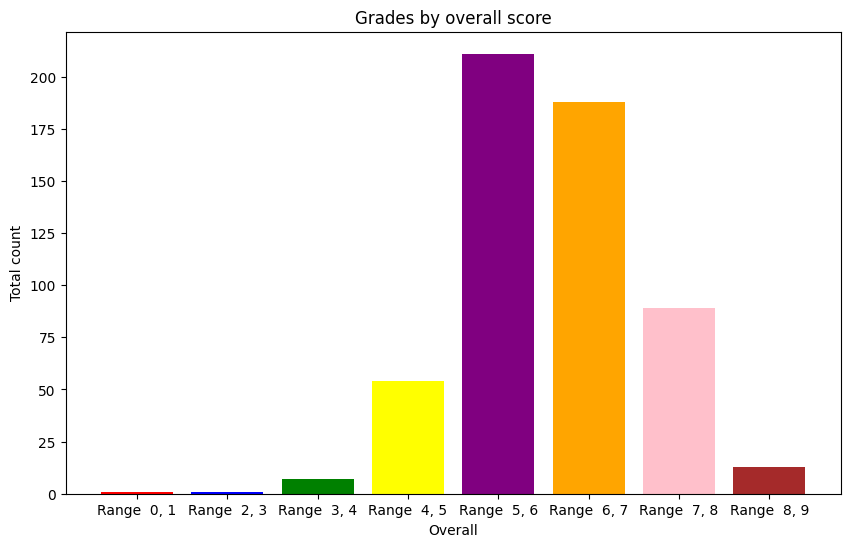

In [ ]:
import matplotlib.pyplot as plt

# Create bins for the 'Overall' column.
# Due to range and int behavior, it is necessary to add 2 to the max result
bins = pd.cut(df_filtered_nm['Overall'], bins=range(0, int(df_filtered_nm['Overall'].max()) + 2))
# Group by these bins and count. Added observed=True for compatibility purposes
df_filtered_scr_grp = df_filtered_nm['Overall'].groupby(bins, observed=True).count()
# Convert the result to a DataFrame and rename the column
# reset_index method is called to convert the grouped index back to columns.
df_filtered_scr_grp = df_filtered_scr_grp.rename("Count").reset_index()
# Fix text ranges to improve the plot
df_filtered_scr_grp['Overall'] = df_filtered_scr_grp['Overall'].astype(str)
df_filtered_scr_grp['Overall'] = 'Range ' + ' ' + df_filtered_scr_grp['Overall'].str[1:-1]

# Generate the barplot
generate_barplot(list(df_filtered_scr_grp['Overall']), list(df_filtered_scr_grp['Count']),
               ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan'],
               'Grades by overall score', 'Overall', 'Total count', (10,6))

As mentioned before, the classification is going to be performed only on B and C bands. For the IELTS test, we have the following equivalence:
* B = 4 to 6.5
* C = 6.6 to 9

For PGWP, the CLB level must be above 5, converted into IELTS writing score, 5.0. The data with scores below 5 is discarded. In addition, it is going to be converted to comply with the scales. For analysis purposes, band B will be class 0 and band C class 1.

In [5]:
# Convert the column to work with float
df_filtered_nm['Overall'] = df_filtered_nm['Overall'].astype(float)
# Filtering the data
df_filtered_fil = df_filtered_nm[df_filtered_nm['Overall'] >= 5.0]
# Create bins for the 'Overall' column.
df_filtered_fil['Overall_band'] = pd.cut(df_filtered_fil['Overall'], bins=[3.9, 6.5, 10], labels=[0, 1]).astype(int)

<ipython-input-5-b83f12978f2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_fil['Overall_band'] = pd.cut(df_filtered_fil['Overall'], bins=[3.9, 6.5, 10], labels=[0, 1]).astype(int)


Lets see a new plot of the Overall_band.

In [ ]:
def generate_piechart(labels, data, colors, title, size):
    plt.figure(figsize=size)
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title)
    plt.show()

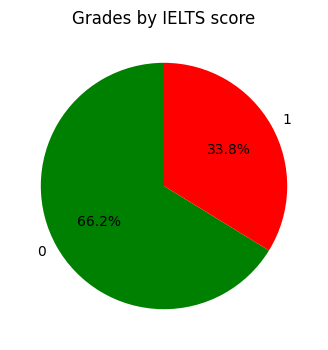

In [ ]:
bands = df_filtered_fil['Overall_band'].unique()
data = df_filtered_fil.groupby('Overall_band', observed=True).count()

generate_piechart(list(bands), list(data['Overall']), ['green', 'red'], 'Grades by IELTS score', (6,4))

There are more C band essays in the present dataset. It is considered normal due to the requirements to achieve this band.

Let's analyze two essays using the wordcloud technique. First, a function to generate the cloud is created. Then, the first essay will be plotted.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Defining a function to generate Word Cloud
def wordcloud_plot(figsize, bck_color, file_content):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color=bck_color, collocations=False).generate(' '.join(file_content))

    # Display the generated word cloud
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes
    plt.show()

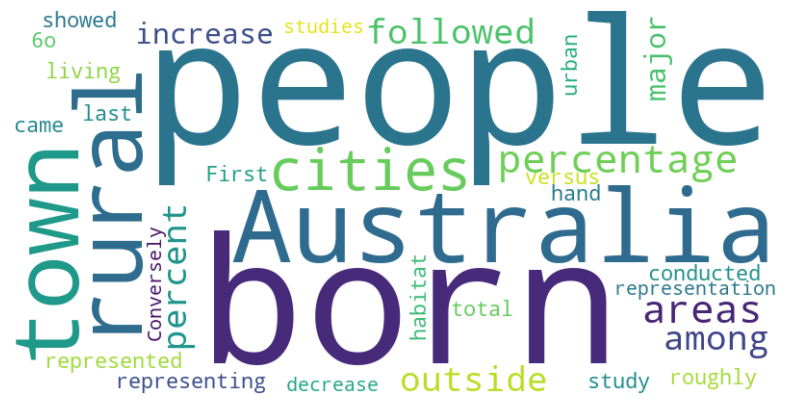

In [ ]:
data = df_filtered_fil.loc[0, 'Essay']
data = data.split('.')

wordcloud_plot((10, 5), 'white', data)

An interesting essay, possibly talking about people born in certain towns in Australia. Let's check another plot but with an essay in C band.

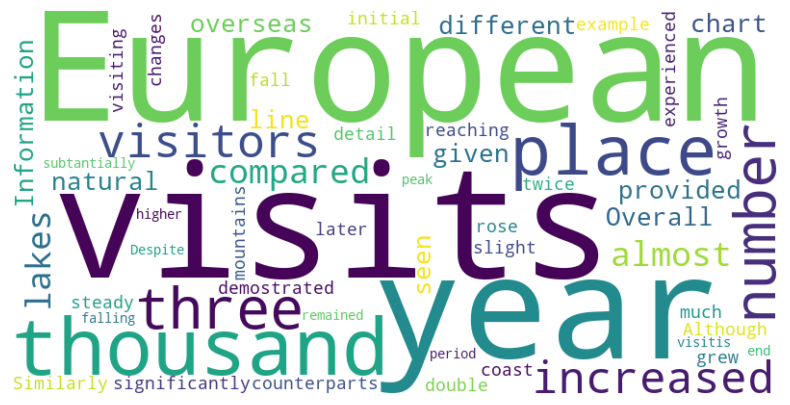

In [ ]:
data = df_filtered_fil[df_filtered_fil['Overall_band'] == 1]['Essay']
data = data.iloc[0]
data = data.split('.')

wordcloud_plot((10, 5), 'white', data)

There are clear differences between both plots that allow us to identify in which band the text is. The quality of the words used in each essay places them in their bands. In addition, in the essay in C band, the cloud shows that there are more vocabulary used.

## 3. Cleaning the Text Document

Due to the nature of the present project, two fine-grain approaches will be defined to clean the essays. These will be defined as follows:

### Pipeline 1 - Traditional fine grained

For grammar analysis purposes, a fine-grain process must be defined. Here is the list of the processes performed in the first pipeline:
- Lower casing
- Removing punctuation
- Handling whitespace
- Removing stop words
- Remove numbers
- Tokenization
- Lemmatization
- Part-of-Speech Tagging (fine-grained)
- Named Entity Recognition (NER)
- Syntactic Parsing and depending

This is a more 'traditional' fine grain in which details relevant to grammar are included. The first step is to remove details such as punctuation, whitespace, and stop words. For these steps, the pipeline is not considered so deep in grain. In the last four steps, Part-of-Speech fine-grained, Named Entity Recognition, Syntactic Parsing and depending are included to add more details. \
The following code implements the previously explained steps:

In [6]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [7]:
# Defining the function for pipeline1
def pipeline1(text):
    # Lower casing
    text_lower_case = text.lower()
    # Loading to the model
    doc = nlp(text_lower_case)
    tokens_lemmatized = []
    dependency = []
    pos_fine_grain = []
    for token in doc:
        # Removing: punctuation, whitespace, stop words, numbers
        if (not token.is_punct) and \
            (not token.is_space) and \
            (not token.is_stop) and \
            (not token.is_digit):
            # Tokenization and lemmatization
            tokens_lemmatized.append(token.lemma_)
            # Syntactic Parsing and depending
            dependency.append((token.text, token.dep_, token.head.text))
            # Part-of-Speech Tagging (fine-grained)
            pos_fine_grain.append((token.text, token.tag_))

    tokens_lemmatized = ' '.join(tokens_lemmatized)

    # Name entity recognition
    doc2 = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc2.ents]

    return tokens_lemmatized, dependency, entities, pos_fine_grain

In [16]:
# Processing the data
full_data_pip1 = []
for text in df_filtered_fil['Essay']:
    pip1_tkn_lmm, pip1_dpn, pip1_ent, pip1_pos_fg = pipeline1(text)
    full_data_pip1.append([pip1_tkn_lmm, pip1_dpn, pip1_ent, pip1_pos_fg])

In [ ]:
# Checking the saved information
full_data_pip1[0]

['study conduct represent percentage people bear australia versus people bear outside australia live urban rural town city represent major percentage habitat roughly percent follow rural area town come people bear australia hand people bear outside australia city show percentage 6o percent follow rural area town people bear australia city increase percent increase total representation major decrease town rural area conversely people bear outside australia city percentage study follow rural area town',
 [('study', 'nsubjpass', 'conducted'),
  ('conducted', 'ROOT', 'conducted'),
  ('representing', 'advcl', 'conducted'),
  ('percentages', 'dobj', 'representing'),
  ('people', 'pobj', 'of'),
  ('born', 'acl', 'people'),
  ('australia', 'pobj', 'in'),
  ('versus', 'prep', 'percentages'),
  ('people', 'pobj', 'versus'),
  ('born', 'acl', 'people'),
  ('outside', 'prep', 'born'),
  ('australia', 'pobj', 'outside'),
  ('living', 'acl', 'percentages'),
  ('urban', 'amod', 'in'),
  ('rural', 'co

### Pipeline 2 - Deep fine grained

The second pipeline will have three key differences from the first one. Three elements are not going to be removed:
- Punctuation
- Stop words
- Numbers
  
This means that the pipeline will be 'deep' fine-grained. There are grammar rules that are considered for the IELTS evaluations for the previous three points. Punctuation adds clarity and improves the structure of the writing. Stop words provide connection between phrases and provide transitions. Numbers must be writing properly to get better scores.\
The pipeline code is implemented in the following cells:

In [8]:
# Defining the function for pipeline2
def pipeline2(text):
    # Lower casing
    text_lower_case = text.lower()
    # Loading to the model
    doc = nlp(text_lower_case)
    tokens_lemmatized = []
    dependency = []
    pos_fine_grain = []
    for token in doc:
        # Removing: punctuation, whitespace, stop words, numbers
        if (not token.is_space):
            # Tokenization and lemmatization
            tokens_lemmatized.append(token.lemma_)
            # Syntactic Parsing and depending
            dependency.append((token.text, token.dep_, token.head.text))
            # Part-of-Speech Tagging (fine-grained)
            pos_fine_grain.append((token.text, token.tag_))

    tokens_lemmatized = ' '.join(tokens_lemmatized)

    # Name entity recognition
    doc2 = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc2.ents]

    return tokens_lemmatized, dependency, entities, pos_fine_grain

In [9]:
# Processing the data
full_data_pip2 = []
for text in df_filtered_fil['Essay']:
    pip2_tkn_lmm, pip2_dpn, pip2_ent, pip2_pos_fg = pipeline2(text)
    full_data_pip2.append([pip2_tkn_lmm, pip2_dpn, pip2_ent, pip2_pos_fg])

In [ ]:
# Checking the saved information
full_data_pip2[0]

['between 1995 and 2010 , a study be conduct represent the percentage of people bear in australia , versus people bear outside australia , live in urban , rural , and town . first , in 1995 , city represent the major percentage of habitat by roughly 50 percent , follow by rural area and town come in last , among people bear in australia . on the other hand , people bear outside australia , city show the most percentage of 6o percent , follow by rural area and town . in 2010 , among people bear in australia , city have an increase more than 20 percent increase in the total representation and a major decrease in town and rural area . conversely , people bear outside australia , city have the most percentage among both study , follow by rural area and town .',
 [('between', 'prep', 'conducted'),
  ('1995', 'pobj', 'between'),
  ('and', 'cc', '1995'),
  ('2010', 'conj', '1995'),
  (',', 'punct', 'conducted'),
  ('a', 'det', 'study'),
  ('study', 'nsubjpass', 'conducted'),
  ('was', 'auxpas

The results of the pipeline process are widely different. The pipeline2 generated a more extensive list with detailed data from the given data.

## 4.Implementation of Word Embedding Methods

Three-word embedding methods will be implemented. The methods are the following:
- BERT: Due to its bidirectional nature, BERT captures the context more effectively. This can help us to understand deeply the sentence structure, meaning, and grammar use. For this case, and thank to th tearche's analysis, a contextual representation is used due to future classification purposes.
- TF-IDF: This method highlights important words and their specific relevance in the document. This can help us to verify if the words are related and consistent with the topic of the task.
- SpaCy: Generates numerical embeddings of the entire document. The main idea is to capture the semantic meaning of the text. The process works with the mean of the individual token vectors, providing a holistic representation of the text.

The next sections implement the three methods as functions to use them later.

### 4.1  BERT

In [10]:
from transformers import BertTokenizer, BertModel
import torch

def vectorize_bert(text):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased')

    # Encode text and returning it as PyTorch tensor
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors="pt")

    # Get the hidden states from the model
    with torch.no_grad():
        outputs = model(input_ids)

    # Extract the [CLS] token embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]

    return cls_embedding

### 4.2 TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_tfidf(documents):
    # Initialize TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the documents
    X = vectorizer.fit_transform(documents)

    # Convert to array and show the result
    tfidf_vector = X.toarray()

    return tfidf_vector

### 4.3 SpaCy

In [12]:
def vectorize_spacy(text):
    doc = nlp(text)
    # vectorizing with SpaCy
    vector = doc.vector

    return vector

## 5. Comparison of the Results of Word Embedding Methods

The comparison is perfomed using two metrics:
- **Cosine similarity:** Measures the similarity between two vectors. The result comes between -1 and 1. When it is -1, the vectors are opposed; when it is 1, the vectors are identical.
- **Cosine distance:** Measures the dissimilarity between two vectors. It can calculated from the previous one (1 - Cosine similarity). for the present project, it is calculated with the complete formula for precision purposes.

The results of the previous methods will be plot to get a visual representation and better understanding of the numerical results.

In [13]:
import numpy as np
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

# Function to calculate the similarity and dissimilarity based on cosine of results
def cos_sim_dis(par1, par2):
    # Formating texts
    par_lst1 = [par1]
    par_lst2 = [par2]

    # Vectorization section
    # BERT
    vec_brt_p1 = np.array(vectorize_bert(par1))
    vec_brt_p2 = np.array(vectorize_bert(par2))
    # TF-IDF
    vec_tfi_p1 = np.array(vectorize_tfidf(par_lst1))
    vec_tfi_p2 = np.array(vectorize_tfidf(par_lst2))
    # SpaCy
    vec_spc_p1 = np.array(vectorize_spacy(par1))
    vec_spc_p2 = np.array(vectorize_spacy(par2))

    # Calculating similarities and dissimilarities
    # BERT
    cos_dst_brt = cosine_distances(vec_brt_p1, vec_brt_p2)
    cos_sim_brt = cosine_similarity(vec_brt_p1, vec_brt_p2)
    # TF-IDF
    cos_dst_tfi = np.dot(vec_tfi_p1.transpose(),vec_tfi_p2)/(norm(vec_tfi_p1.transpose())*norm(vec_tfi_p2))
    cos_sim_tfi = cosine_similarity(vec_tfi_p1.transpose(), vec_tfi_p2.transpose())
    # SpaCy
    cos_dst_spc = np.dot(vec_spc_p1,vec_spc_p2)/(norm(vec_spc_p1)*norm(vec_spc_p2))
    cos_sim_spc = cosine_similarity(vec_spc_p1.reshape(-1, 1), vec_spc_p2.reshape(-1, 1))

    return cos_sim_brt, cos_dst_brt, cos_sim_tfi, cos_dst_tfi, cos_sim_spc, cos_dst_spc

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to plot the vectors
def plot_vectors(par1, par2, method, title, x_label, y_label):
    # BERT
    if method == 'BERT':
      vec_p1 = np.array(vectorize_bert(par1))
      vec_p2 = np.array(vectorize_bert(par2))
      # Arranging the pairs to plot
      vec_p1_t = vec_p1.T
      vec_p2_t = vec_p2.T
      # Generating pairs as (x, y)
      vec_p1 = np.array([[i+1, value[0]] for i, value in enumerate(vec_p1_t)])
      vec_p2 = np.array([[i+1, value[0]] for i, value in enumerate(vec_p2_t)])
      label_p1 = 'BERT_pipeline1'
      label_p2 = 'BERT_pipeline2'

    # TF-IDF
    if method == 'TF-IDF':
      vec_p1 = np.array(vectorize_tfidf([par1]))
      vec_p2 = np.array(vectorize_tfidf([par2]))
      # Arranging the pairs to plot
      vec_p1_t = vec_p1.T
      vec_p2_t = vec_p2.T
      # Generating pairs as (x, y)
      vec_p1 = np.array([[i+1, value[0]] for i, value in enumerate(vec_p1_t)])
      vec_p2 = np.array([[i+1, value[0]] for i, value in enumerate(vec_p2_t)])
      label_p1 = 'TF-IDF_pipeline1'
      label_p2 = 'TF-IDF_pipeline2'

    # SpaCy
    if method == 'SpaCy':
      vec_p1 = np.array(vectorize_spacy(par1))
      vec_p2 = np.array(vectorize_spacy(par2))
      # Arranging the pairs to plot
      vec_p1 = np.array([[i+1, value] for i, value in enumerate(vec_p1)])
      vec_p2 = np.array([[i+1, value] for i, value in enumerate(vec_p2)])
      label_p1 = 'SpaCy_pipeline1'
      label_p2 = 'SpaCy_pipeline2'

    # Plot the reduced embeddings
    plt.scatter(vec_p1[:, 0], vec_p1[:, 1], color='blue', label=label_p1)
    plt.scatter(vec_p2[:, 0], vec_p2[:, 1], color='red', label=label_p2)
    plt.title(title, fontweight ='bold', fontsize = 15)
    plt.xlabel(x_label, fontweight ='bold', fontsize = 15)
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15)
    plt.legend()
    plt.show()

### 5.1 Pipeline1 vs Pipeline2 - BERT method results comparison

For BERT method, the pipelines present a moderate similarity between them. Conceptually, BERT captures the context of a text bidirectionally. In addition, the cotextual representation of the approach, weights more this feature of the algorithm. In this case, the deep grain value of pipeline2 does not add significant information to change the context of both pipelines. Thus, BERT consider that both has similar context. The disimilarity value (cosine distance) support the conclusion.

In [17]:
brt_cos_sim, brt_cos_dis, _, _, _, _ = cos_sim_dis(full_data_pip1[0][0], full_data_pip2[0][0])
print("Bert pipeline1 vs pipeline2")
print("Cosine similarity for Vectorization with BERT:")
print(brt_cos_sim)
print("Cosine distance for Vectorization with BERT:")
print(brt_cos_dis)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert pipeline1 vs pipeline2
Cosine similarity for Vectorization with BERT:
[[0.6761397]]
Cosine distance for Vectorization with BERT:
[[0.3238603]]


The plot visually shows the consistent context in both pipelines. The main idea is there and is similar in both pipelines, but, the finest-grain addition in pipeline2 adds the difference between both vectors.

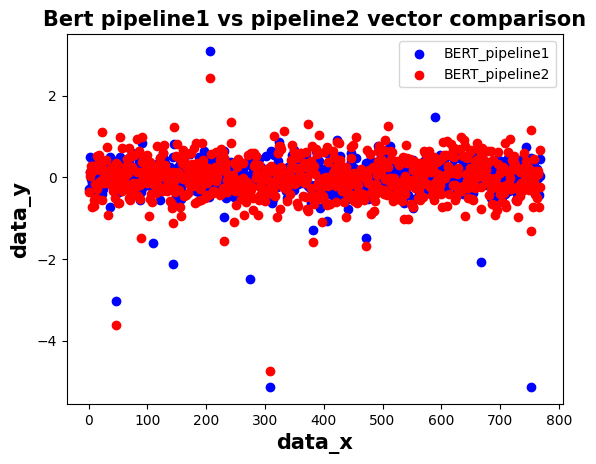

In [18]:
plot_vectors(full_data_pip1[0][0], full_data_pip2[0][0], 'BERT', 'Bert pipeline1 vs pipeline2 vector comparison', 'data_x', 'data_y')

### 5.2 Pipeline1 vs Pipeline2 - TF-IDF method results comparison

For TF-IDF method, the proccess presents particular results. The vectors are almost equal according with similarity. The result is consistent with the dissimilarity values. TF-IDF reflect how important a word is to a document in a corpus. As conclusion, the fine-grained additions in pipeline2 does not affect the calculations in TF-IDF. The added value it is not numerically important for this method. \
TF-IDF results does not make so much difference in finest-grained methods. The probable reason is due to the nature of the method. To get better results is necessary to modify the pipelines in pro of the nature of the method.

In [19]:
_, _, tfi_cos_sim, tfi_cos_dis, _, _ = cos_sim_dis(full_data_pip1[0][0], full_data_pip2[0][0])

print("TF-IDF pipeline1 vs pipeline2")
print("Cosine similarity for Vectorization with TF-IDF:")
print(tfi_cos_sim)
print("Cosine distance for Vectorization with TF-IDF:")
print(tfi_cos_dis)

TF-IDF pipeline1 vs pipeline2
Cosine similarity for Vectorization with TF-IDF:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Cosine distance for Vectorization with TF-IDF:
[[0.00556559 0.0027828  0.00556559 ... 0.01391398 0.0027828  0.0027828 ]
 [0.02226237 0.01113118 0.02226237 ... 0.05565592 0.01113118 0.01113118]
 [0.03339355 0.01669678 0.03339355 ... 0.08348388 0.01669678 0.01669678]
 ...
 [0.02782796 0.01391398 0.02782796 ... 0.0695699  0.01391398 0.01391398]
 [0.00556559 0.0027828  0.00556559 ... 0.01391398 0.0027828  0.0027828 ]
 [0.00556559 0.0027828  0.00556559 ... 0.01391398 0.0027828  0.0027828 ]]


The plot evidence the results of the previous calculations. Considering thet the values are below 0.5 in y-axis and most of the values fall below 0.2, the plot confirms the similarity and dissimilarity values.

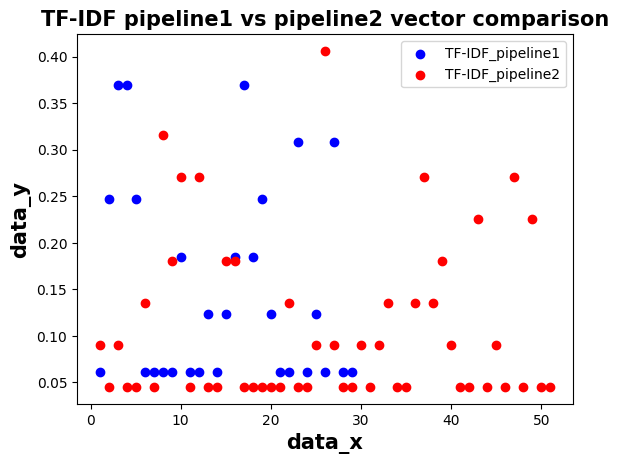

In [20]:
plot_vectors(full_data_pip1[0][0], full_data_pip2[0][0], 'TF-IDF', 'TF-IDF pipeline1 vs pipeline2 vector comparison', 'data_x', 'data_y')

### 5.3 Pipeline1 vs Pipeline2 - SpaCy method results comparison

For SpaCy method, the results are mixed between exact similarity and dissimilarity. This vector represents the semantic meaning of the text. This meaning is holistic, calculated by the average of the vectors. As conclusion, the pipeline2 with the fine grained approch added the dissimilarity over the extra considerations such as punctuation and stop words. However, on it base process, the numerical results are still the same. In addition, the dissimilarity calculation is a better measure to consider in this step due to its precision. \
SpaCy gives valuable dissimilarity results. The finest-grain process does not add relevant data to the vector. Overall, for this process, the pipeline2 is not quite different of pipeline1.

In [21]:
_, _, _, _, spc_cos_sim, spc_cos_dis = cos_sim_dis(full_data_pip1[0][0], full_data_pip2[0][0])

print("SpaCy pipeline1 vs pipeline2")
print("Cosine similarity for Vectorization with SpaCy:")
print(spc_cos_sim)
print("Cosine distance for Vectorization with SpaCy:")
print(spc_cos_dis)

SpaCy pipeline1 vs pipeline2
Cosine similarity for Vectorization with SpaCy:
[[ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]
 [ 1.  1.  1. ...  1.  1. -1.]
 ...
 [ 1.  1.  1. ...  1.  1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]]
Cosine distance for Vectorization with SpaCy:
0.8465597


The plot shows the overlap, proximity, and opposite direction of the points between the data two vectors. The dissimilarity value is consistent with the plot.

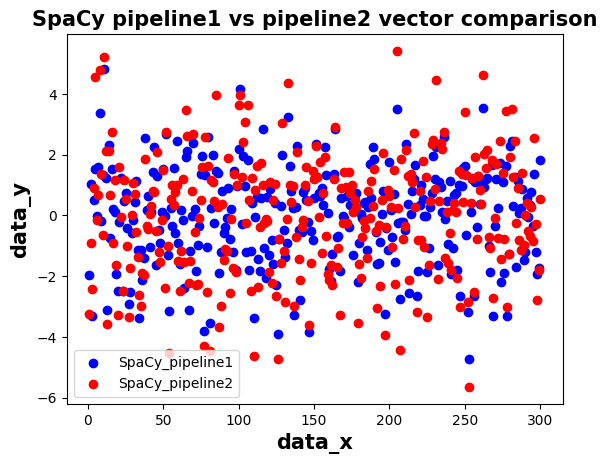

In [22]:
plot_vectors(full_data_pip1[0][0], full_data_pip2[0][0], 'SpaCy', 'SpaCy pipeline1 vs pipeline2 vector comparison', 'data_x', 'data_y')

## Conclusions

The present projects defined two pipelines. Both are fine-grained, but the second includes punctuation, stop words, and numbers. Overall, the three-word embedding techniques used evidenced that the three pairs of vectors generated for the pipelines are moderately similar. Adding the three mentioned text elements to a pipeline does not add a high numerical difference between the resulting vectors. \
It is crucial to point that both pipelines were applied to the same paragraph. BERT, being a more contextual focused algorithm, presented less similar values. The elements included add enough context to differentiate them. TF-IDF works with relevance of words in context. The elements added are not that important so the results are almost equal. SpaCy has a more semantic approach. The added elements do not add more meaning to the sentence, thus have high similarity.